
# Universidad de Buenos Aires
# Deep Learning - Examen - Parte 2
# Diciembre 2023


El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el Domingo 24 de diciembre. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (compartir a las siguientes direcciones: maxit1992@gmail.com y lelectronfou@gmail.com). Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-Examen AGOSTO 2023.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.

## Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset fashion MNIST las 10 clases del mismo. Sobre dicho modelo, realize una exploración de 5 variantes distintas (que se desprenden del modelo propuesto) variando alguno (o varios) de los siguientes hiperparámetros
- numero de capas.
- numero de kernels.
- tamaño de kernels.


a) Evalue la evolución de la función de perdida y la accuracy (para train y test) para cada modelo y elija el que considera mejor.

b) Al mejor modelo, aplique capas de dropout para ver si puede mejorar sus métricas.



### Preparación y verificación del dataset

In [2]:
# importamos librerías esenciales
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
import numpy as np

In [3]:
# descargamos datos de entrenamiento
train_data= datasets.FashionMNIST(root= 'data', train= True, download= True, transform= ToTensor(),)

# descargamos datos de testeo
test_data= datasets.FashionMNIST(root= 'data', train= False, download= True, transform= ToTensor(),)

100%|██████████| 26421880/26421880 [00:02<00:00, 10302256.80it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 174952.60it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3237504.41it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5738048.63it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



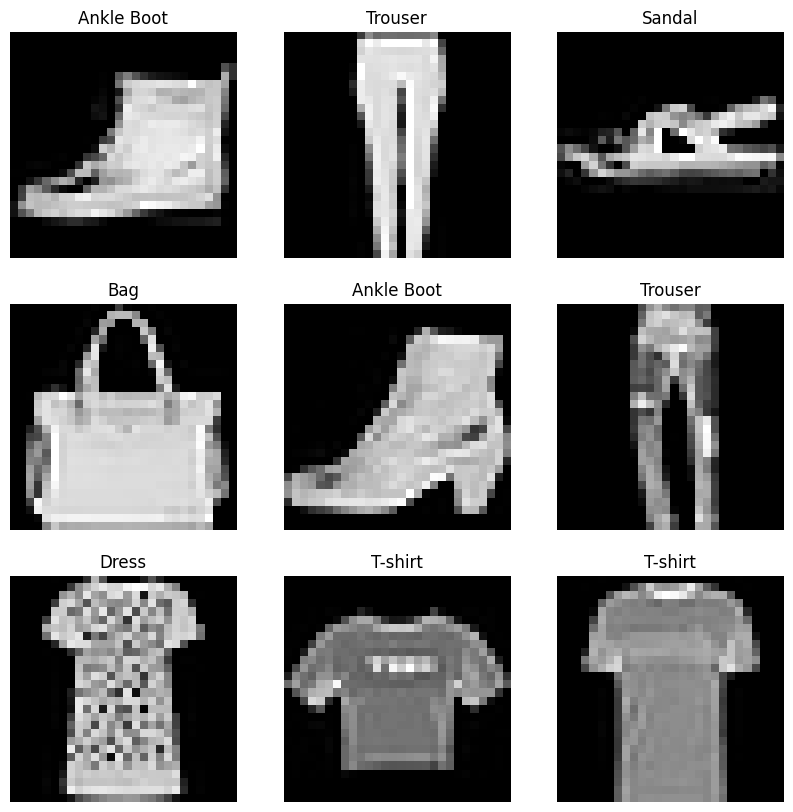

In [4]:
# graficamos todas las clases con sus respectivas etiquetas
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [5]:
# configuramos el device acorde al device disponible
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# creamos los batches con Datalodader
dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

In [7]:
# verificamos los types
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [8]:
# capturamos la imagen y etiqueta del dataloader
train_features, train_labels = next(iter(dataloader['train']))

Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


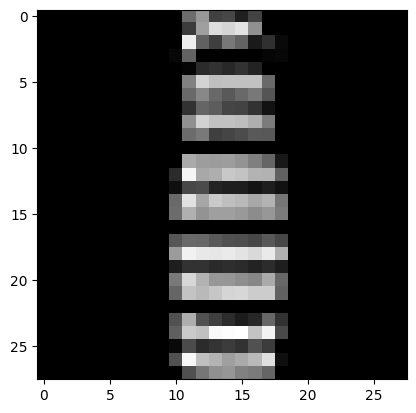

Label: 3


In [9]:
# verificamos las dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[22]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[22]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Creación del _model_0_, nuestro modelo base
Más tarde se crearán otros modelos alternativos, variando los hiperparámetros originales.

In [47]:
# bloque de convolución para emplear en la red
def conv_block(c_in, c_out, k=5, p=2, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

In [12]:
# creamos la clase
class CNN_0(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block(16, 32)
    self.conv3_out = None
    self.fc = torch.nn.Linear(512, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [13]:
model_0= CNN_0()

Red creada
arquitectura:
CNN_0(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  21386


In [14]:
# resumen de la red creada
from torchsummary import summary
summary(model_0.cuda(),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
              Tanh-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           3,216
              Tanh-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 32, 7, 7]          12,832
              Tanh-8             [-1, 32, 7, 7]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Linear-10                   [-1, 10]           5,130
          Softmax-11            [-1, 1, 28, 28]               0
Total params: 21,386
Trainable params: 21,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [37]:
model_0.cpu()
model_0.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 14, 14])
Tamaño salida conv2:  torch.Size([1, 16, 7, 7])
Tamaño salida conv3:  torch.Size([1, 32, 4, 4])
Tamaño imagen vectorizada:  torch.Size([1, 512])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


In [15]:
# definimos la función necesaria para el entrenamiento, graficando las métricas de entrenamiento y testeo
def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))

    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

    return {
        'model': model,
        'optimizer': optimizer,
    }

val_loss 0.67020 val_acc 0.75746: 100%|██████████| 157/157 [00:01<00:00, 87.88it/s]


Epoch 1/5 loss 1.04236 val_loss 0.67020 acc 0.65590 val_acc 0.75746


val_loss 0.56896 val_acc 0.79080: 100%|██████████| 157/157 [00:01<00:00, 88.22it/s]


Epoch 2/5 loss 0.59573 val_loss 0.56896 acc 0.77993 val_acc 0.79080


val_loss 0.51521 val_acc 0.81071: 100%|██████████| 157/157 [00:01<00:00, 88.30it/s]


Epoch 3/5 loss 0.52227 val_loss 0.51521 acc 0.80830 val_acc 0.81071


val_loss 0.47513 val_acc 0.82385: 100%|██████████| 157/157 [00:02<00:00, 77.92it/s]


Epoch 4/5 loss 0.47576 val_loss 0.47513 acc 0.82508 val_acc 0.82385


val_loss 0.44769 val_acc 0.83529: 100%|██████████| 157/157 [00:02<00:00, 69.70it/s]


Epoch 5/5 loss 0.44175 val_loss 0.44769 acc 0.83850 val_acc 0.83529


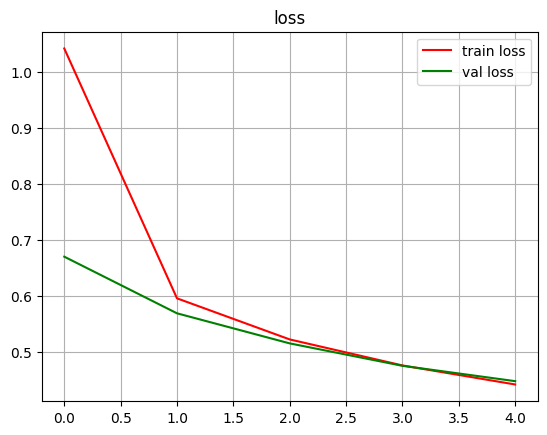

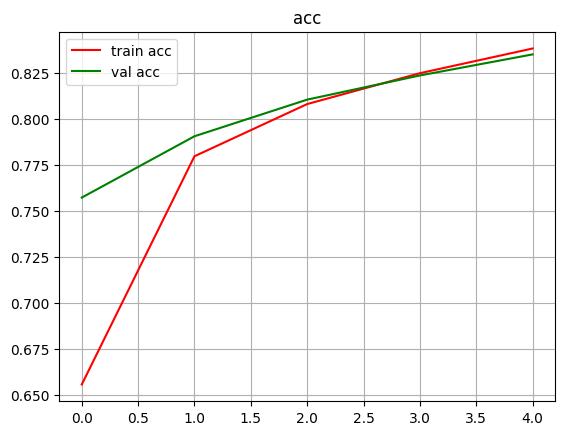

In [53]:
results_model_0= fit(model_0, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **8 kernels** de **tamaño 5x5**:

- train loss = 0.44175
- validation loss = 0.44769

- train accuracy = 83.850%
- validation accuracy = 83.529%

***

### Creación del _model_1_
Una capa de convolución adicional (4 en total).

In [54]:
# creamos la clase
class CNN_1(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block(16, 32)
    self.conv3_out = None
    self.conv4 = conv_block(32, 64)
    self.conv4_out = None
    self.fc = torch.nn.Linear(256, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [56]:
model_1= CNN_1()

Red creada
arquitectura:
CNN_1(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  6
Número total de

In [ ]:
# resumen de la red
summary(model_1.cuda(),(1, 28, 28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
              Tanh-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           3,216
              Tanh-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 32, 7, 7]          12,832
              Tanh-8             [-1, 32, 7, 7]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          51,264
             Tanh-11             [-1, 64, 4, 4]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Linear-13                   [-1, 10]           2,570
          Softmax-14            [-1, 1,

In [ ]:
model_1.cpu()
model_1.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 14, 14])
Tamaño salida conv2:  torch.Size([1, 16, 7, 7])
Tamaño salida conv3:  torch.Size([1, 32, 4, 4])
Tamaño salida conv4:  torch.Size([1, 64, 2, 2])
Tamaño imagen vectorizada:  torch.Size([1, 256])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


val_loss 0.64054 val_acc 0.75587: 100%|██████████| 157/157 [00:01<00:00, 90.51it/s]


Epoch 1/5 loss 0.98544 val_loss 0.64054 acc 0.66430 val_acc 0.75587


val_loss 0.54726 val_acc 0.79638: 100%|██████████| 157/157 [00:02<00:00, 73.10it/s]


Epoch 2/5 loss 0.57058 val_loss 0.54726 acc 0.78337 val_acc 0.79638


val_loss 0.49401 val_acc 0.81618: 100%|██████████| 157/157 [00:01<00:00, 87.59it/s]


Epoch 3/5 loss 0.50001 val_loss 0.49401 acc 0.81228 val_acc 0.81618


val_loss 0.45379 val_acc 0.82902: 100%|██████████| 157/157 [00:01<00:00, 88.52it/s]


Epoch 4/5 loss 0.45341 val_loss 0.45379 acc 0.83164 val_acc 0.82902


val_loss 0.43305 val_acc 0.83748: 100%|██████████| 157/157 [00:01<00:00, 89.77it/s]


Epoch 5/5 loss 0.42017 val_loss 0.43305 acc 0.84433 val_acc 0.83748


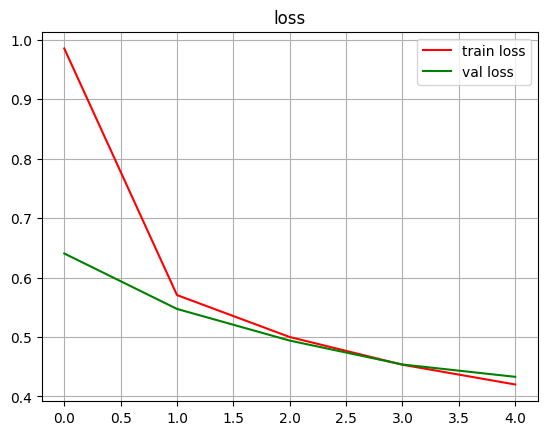

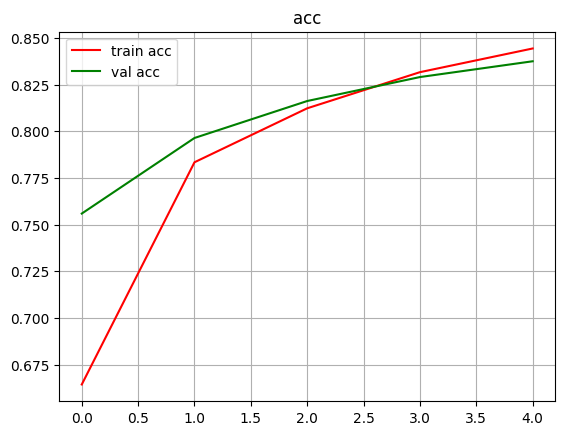

In [57]:
results_model_1= fit(model_1, dataloader, epochs=5)

Métricas obtenidas para un modelo con **4 capas de convolución**, **8 kernels** de **tamaño 5x5**:

- train loss = 0.42017
- validation loss = 0.43305

- train accuracy = 84.433%
- validation accuracy = 83.748%

***

### Creación del _model_2_
Aumentamos el número de kernels (16 en la primer capa).

In [58]:
# creamos la clase
class CNN_2(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 16)
    self.conv1_out = None
    self.conv2 = conv_block(16, 32)
    self.conv2_out = None
    self.conv3 = conv_block(32, 64)
    self.conv3_out = None
    self.fc = torch.nn.Linear(1024, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [59]:
model_2= CNN_2()

Red creada
arquitectura:
CNN_2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1024, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  74762


In [ ]:
# resumen de la red
summary(model_2.cuda(),(1, 28, 28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              Tanh-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
              Tanh-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          51,264
              Tanh-8             [-1, 64, 7, 7]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                   [-1, 10]          10,250
          Softmax-11            [-1, 1, 28, 28]               0
Total params: 74,762
Trainable params: 74,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
model_2.cpu()
model_2.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 16, 14, 14])
Tamaño salida conv2:  torch.Size([1, 32, 7, 7])
Tamaño salida conv3:  torch.Size([1, 64, 4, 4])
Tamaño imagen vectorizada:  torch.Size([1, 1024])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


val_loss 0.57079 val_acc 0.78782: 100%|██████████| 157/157 [00:02<00:00, 78.46it/s]


Epoch 1/5 loss 0.81409 val_loss 0.57079 acc 0.73083 val_acc 0.78782


val_loss 0.47627 val_acc 0.82594: 100%|██████████| 157/157 [00:02<00:00, 77.08it/s]


Epoch 2/5 loss 0.50022 val_loss 0.47627 acc 0.81615 val_acc 0.82594


val_loss 0.42636 val_acc 0.84664: 100%|██████████| 157/157 [00:01<00:00, 81.19it/s]


Epoch 3/5 loss 0.43115 val_loss 0.42636 acc 0.84268 val_acc 0.84664


val_loss 0.40089 val_acc 0.85510: 100%|██████████| 157/157 [00:01<00:00, 91.03it/s]


Epoch 4/5 loss 0.38716 val_loss 0.40089 acc 0.86039 val_acc 0.85510


val_loss 0.37365 val_acc 0.86346: 100%|██████████| 157/157 [00:01<00:00, 93.44it/s]


Epoch 5/5 loss 0.35914 val_loss 0.37365 acc 0.86959 val_acc 0.86346


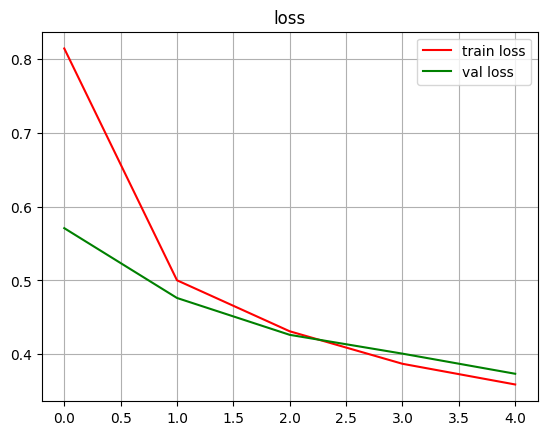

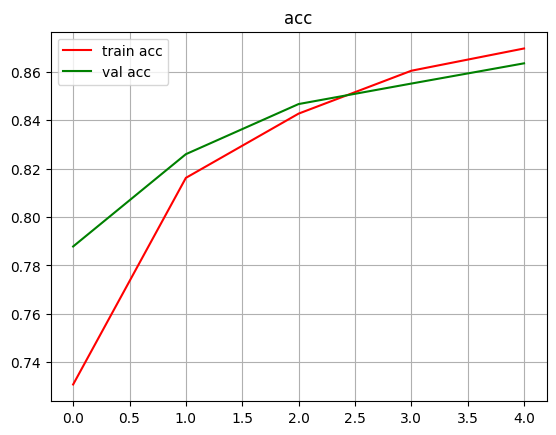

In [60]:
results_model_2= fit(model_2, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **16 kernels** de **tamaño 5x5**:

- train loss = 0.35914
- validation loss = 0.37365

- train accuracy = 86.959%
- validation accuracy = 86.346%

***

### Creación del _model_3_
Se reduce el tamaño de los kernels (quedan en 3x3).

In [61]:
# bloque de convolución para emplear en la red

def conv_block_1(c_in, c_out, k=3, p=2, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

In [62]:
# creamos la clase
class CNN_3(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block_1(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block_1(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block_1(16, 32)
    self.conv3_out = None
    self.fc = torch.nn.Linear(1152, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [63]:
model_3= CNN_3()

Red creada
arquitectura:
CNN_3(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1152, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  17418


In [ ]:
# resumen de la red
summary(model_3.cuda(),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]              80
              Tanh-2            [-1, 8, 30, 30]               0
         MaxPool2d-3            [-1, 8, 15, 15]               0
            Conv2d-4           [-1, 16, 17, 17]           1,168
              Tanh-5           [-1, 16, 17, 17]               0
         MaxPool2d-6             [-1, 16, 9, 9]               0
            Conv2d-7           [-1, 32, 11, 11]           4,640
              Tanh-8           [-1, 32, 11, 11]               0
         MaxPool2d-9             [-1, 32, 6, 6]               0
           Linear-10                   [-1, 10]          11,530
          Softmax-11            [-1, 1, 28, 28]               0
Total params: 17,418
Trainable params: 17,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
model_3.cpu()
model_3.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 15, 15])
Tamaño salida conv2:  torch.Size([1, 16, 9, 9])
Tamaño salida conv3:  torch.Size([1, 32, 6, 6])
Tamaño imagen vectorizada:  torch.Size([1, 1152])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


val_loss 0.74277 val_acc 0.74194: 100%|██████████| 157/157 [00:01<00:00, 90.83it/s]


Epoch 1/5 loss 1.13513 val_loss 0.74277 acc 0.62793 val_acc 0.74194


val_loss 0.60416 val_acc 0.78016: 100%|██████████| 157/157 [00:01<00:00, 91.76it/s]


Epoch 2/5 loss 0.64519 val_loss 0.60416 acc 0.77212 val_acc 0.78016


val_loss 0.54207 val_acc 0.80314: 100%|██████████| 157/157 [00:01<00:00, 88.49it/s]


Epoch 3/5 loss 0.55207 val_loss 0.54207 acc 0.80229 val_acc 0.80314


val_loss 0.50346 val_acc 0.81389: 100%|██████████| 157/157 [00:01<00:00, 88.77it/s]


Epoch 4/5 loss 0.50518 val_loss 0.50346 acc 0.81618 val_acc 0.81389


val_loss 0.47735 val_acc 0.82424: 100%|██████████| 157/157 [00:02<00:00, 68.08it/s]


Epoch 5/5 loss 0.47401 val_loss 0.47735 acc 0.82768 val_acc 0.82424


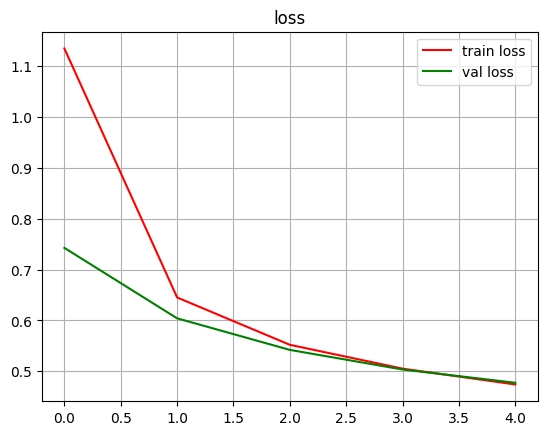

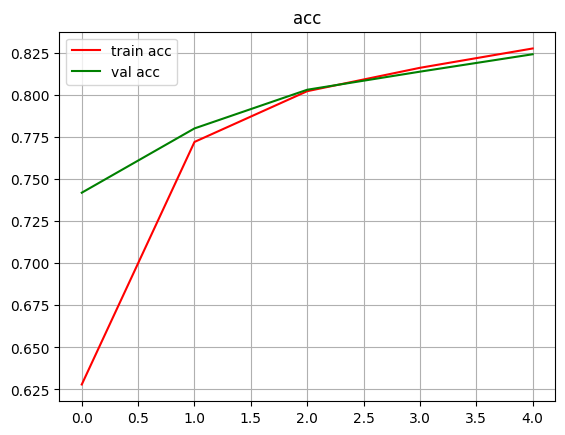

In [64]:
results_3= fit(model_3, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **8 kernels** de **tamaño 3x3**:

- train loss = 0.47401
- validation loss = 0.47735

- train accuracy = 82.768%
- validation accuracy = 82.424%

***

### Creación del _model_4_
Aumentamos aún más el número de kernels (32 en la primer capa).

In [65]:
# creamos la clase
class CNN_4(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 32)
    self.conv1_out = None
    self.conv2 = conv_block(32, 64)
    self.conv2_out = None
    self.conv3 = conv_block(64, 128)
    self.conv3_out = None
    self.fc = torch.nn.Linear(2048, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [66]:
model_4= CNN_4()

Red creada
arquitectura:
CNN_4(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2048, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  277514


In [ ]:
# resumen de la red
summary(model_4.cuda(),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              Tanh-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              Tanh-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]         204,928
              Tanh-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                   [-1, 10]          20,490
          Softmax-11            [-1, 1, 28, 28]               0
Total params: 277,514
Trainable params: 277,514
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
model_4.cpu()
model_4.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 32, 14, 14])
Tamaño salida conv2:  torch.Size([1, 64, 7, 7])
Tamaño salida conv3:  torch.Size([1, 128, 4, 4])
Tamaño imagen vectorizada:  torch.Size([1, 2048])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


val_loss 0.50218 val_acc 0.81310: 100%|██████████| 157/157 [00:02<00:00, 69.38it/s]


Epoch 1/5 loss 0.67860 val_loss 0.50218 acc 0.76229 val_acc 0.81310


val_loss 0.41741 val_acc 0.84684: 100%|██████████| 157/157 [00:01<00:00, 85.54it/s]


Epoch 2/5 loss 0.42611 val_loss 0.41741 acc 0.84430 val_acc 0.84684


val_loss 0.36400 val_acc 0.86833: 100%|██████████| 157/157 [00:01<00:00, 82.14it/s]


Epoch 3/5 loss 0.36028 val_loss 0.36400 acc 0.86994 val_acc 0.86833


val_loss 0.33113 val_acc 0.88147: 100%|██████████| 157/157 [00:02<00:00, 66.27it/s]


Epoch 4/5 loss 0.32527 val_loss 0.33113 acc 0.88156 val_acc 0.88147


val_loss 0.31526 val_acc 0.88585: 100%|██████████| 157/157 [00:01<00:00, 83.79it/s]


Epoch 5/5 loss 0.30296 val_loss 0.31526 acc 0.88996 val_acc 0.88585


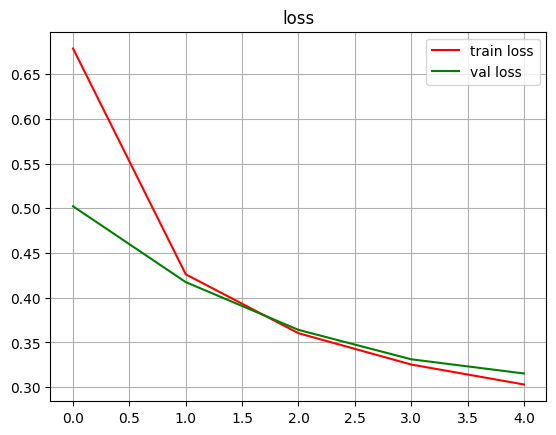

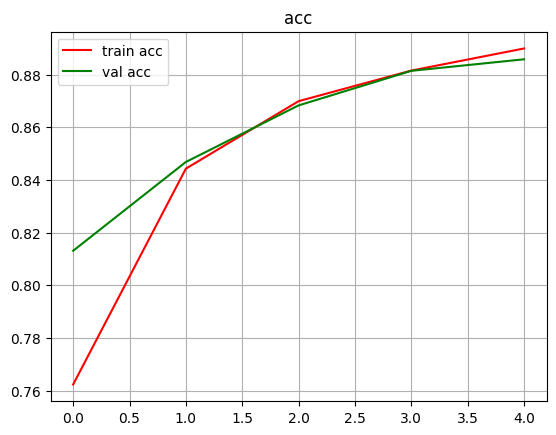

In [67]:
results_model_4= fit(model_4, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **32 kernels** de **tamaño 5x5**:

- train loss = 0.30296
- validation loss = 0.31526

- train accuracy = 88.996%
- validation accuracy = 88.585%

***

### Creación del _model_5_
Se aumenta el tamaño de los kernels (quedan en 7x7).

In [68]:
# bloque de convolución para emplear en la red

def conv_block_2(c_in, c_out, k=7, p=2, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

In [69]:
# creamos la clase
class CNN_5(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block_2(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block_2(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block_2(16, 32)
    self.conv3_out = None
    self.fc = torch.nn.Linear(128, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [70]:
model_5= CNN_5()

Red creada
arquitectura:
CNN_5(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  33098


In [ ]:
# resumen de la red
summary(model_5.cuda(),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]             400
              Tanh-2            [-1, 8, 26, 26]               0
         MaxPool2d-3            [-1, 8, 13, 13]               0
            Conv2d-4           [-1, 16, 11, 11]           6,288
              Tanh-5           [-1, 16, 11, 11]               0
         MaxPool2d-6             [-1, 16, 6, 6]               0
            Conv2d-7             [-1, 32, 4, 4]          25,120
              Tanh-8             [-1, 32, 4, 4]               0
         MaxPool2d-9             [-1, 32, 2, 2]               0
           Linear-10                   [-1, 10]           1,290
          Softmax-11            [-1, 1, 28, 28]               0
Total params: 33,098
Trainable params: 33,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
model_5.cpu()
model_5.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 8, 13, 13])
Tamaño salida conv2:  torch.Size([1, 16, 6, 6])
Tamaño salida conv3:  torch.Size([1, 32, 2, 2])
Tamaño imagen vectorizada:  torch.Size([1, 128])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


val_loss 0.68623 val_acc 0.74423: 100%|██████████| 157/157 [00:01<00:00, 87.65it/s]


Epoch 1/5 loss 1.01719 val_loss 0.68623 acc 0.67252 val_acc 0.74423


val_loss 0.57799 val_acc 0.78732: 100%|██████████| 157/157 [00:01<00:00, 86.23it/s]


Epoch 2/5 loss 0.60822 val_loss 0.57799 acc 0.77111 val_acc 0.78732


val_loss 0.52304 val_acc 0.80494: 100%|██████████| 157/157 [00:01<00:00, 85.47it/s]


Epoch 3/5 loss 0.52971 val_loss 0.52304 acc 0.80166 val_acc 0.80494


val_loss 0.48997 val_acc 0.81529: 100%|██████████| 157/157 [00:02<00:00, 71.03it/s]


Epoch 4/5 loss 0.48201 val_loss 0.48997 acc 0.82268 val_acc 0.81529


val_loss 0.45548 val_acc 0.83280: 100%|██████████| 157/157 [00:01<00:00, 83.30it/s]


Epoch 5/5 loss 0.44894 val_loss 0.45548 acc 0.83592 val_acc 0.83280


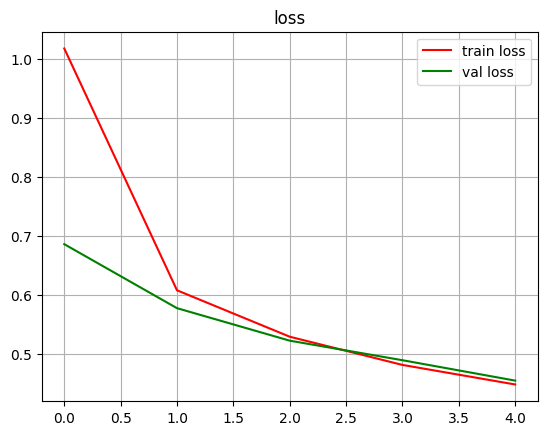

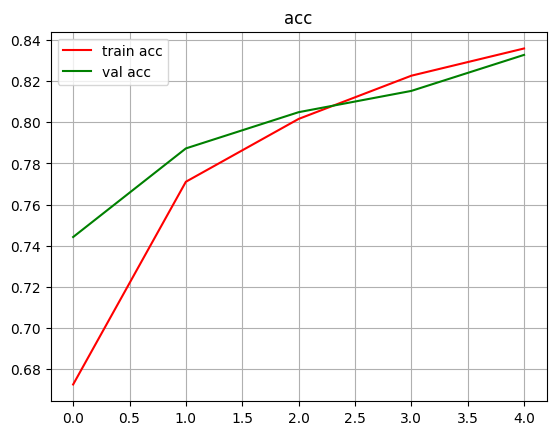

In [71]:
results_model_5= fit(model_5, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **8 kernels** de **tamaño 7x7**:

- train loss = 0.44894
- validation loss = 0.45548

- train accuracy = 83.592%
- validation accuracy = 83.280%

***

### Elección del mejor modelo
Al observar las métricas obtenidas por cada uno de los modelos, se concluye que el mejor desempeño se ha obtenido con el **model_4**, el cual *aumentó el número de kernels en la primer capa de 8 a 32*.

### Adición de capas de dropout
Le añadiremos capas droput a model_4 para intentar mejorar la performance del modelo.

En la siguiente red, añadimos 3 capas de droput intermedias con *p= 0.5*.

In [72]:
# creamos la clase
class CNN_4_dropout(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 32)
    self.conv1_out = None
    self.dropout1 = nn.Dropout(p=0.5)
    self.dropout1_out = None
    self.conv2 = conv_block(32, 64)
    self.conv2_out = None
    self.dropout2 = nn.Dropout(p=0.5)
    self.dropout2_out = None
    self.conv3 = conv_block(64, 128)
    self.conv3_out = None
    self.dropout3 = nn.Dropout(p=0.5)
    self.dropout3_out = None
    self.fc = torch.nn.Linear(2048, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)


    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.dropout1_out = self.dropout1(self.conv1_out)
    self.conv2_out = self.conv2(self.dropout1_out)
    self.dropout2_out = self.dropout2(self.conv2_out)
    self.conv3_out = self.conv3(self.dropout2_out)
    self.dropout3_out = self.dropout3(self.conv3_out)
    y = self.dropout3_out.view(self.dropout3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [73]:
model_4_dropout= CNN_4_dropout()

Red creada
arquitectura:
CNN_4_dropout(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  8
Número total de parámetros a entrenar:  277514


In [ ]:
# resumen de la red
summary(model_4_dropout.cuda(),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              Tanh-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
           Dropout-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          51,264
              Tanh-6           [-1, 64, 14, 14]               0
         MaxPool2d-7             [-1, 64, 7, 7]               0
           Dropout-8             [-1, 64, 7, 7]               0
            Conv2d-9            [-1, 128, 7, 7]         204,928
             Tanh-10            [-1, 128, 7, 7]               0
        MaxPool2d-11            [-1, 128, 4, 4]               0
          Dropout-12            [-1, 128, 4, 4]               0
           Linear-13                   [-1, 10]          20,490
          Softmax-14            [-1, 1,

In [ ]:
model_4_dropout.cpu()
model_4_dropout.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 32, 14, 14])
Tamaño salida conv2:  torch.Size([1, 64, 7, 7])
Tamaño salida conv3:  torch.Size([1, 128, 4, 4])
Tamaño imagen vectorizada:  torch.Size([1, 2048])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


val_loss 0.60275 val_acc 0.77518: 100%|██████████| 157/157 [00:01<00:00, 84.95it/s]


Epoch 1/5 loss 0.89423 val_loss 0.60275 acc 0.67714 val_acc 0.77518


val_loss 0.51372 val_acc 0.80882: 100%|██████████| 157/157 [00:02<00:00, 69.02it/s]


Epoch 2/5 loss 0.57241 val_loss 0.51372 acc 0.78553 val_acc 0.80882


val_loss 0.45623 val_acc 0.83609: 100%|██████████| 157/157 [00:01<00:00, 83.97it/s]


Epoch 3/5 loss 0.50227 val_loss 0.45623 acc 0.81322 val_acc 0.83609


val_loss 0.42646 val_acc 0.84385: 100%|██████████| 157/157 [00:01<00:00, 82.22it/s]


Epoch 4/5 loss 0.45782 val_loss 0.42646 acc 0.83074 val_acc 0.84385


val_loss 0.40407 val_acc 0.85251: 100%|██████████| 157/157 [00:02<00:00, 68.28it/s]


Epoch 5/5 loss 0.42499 val_loss 0.40407 acc 0.84342 val_acc 0.85251


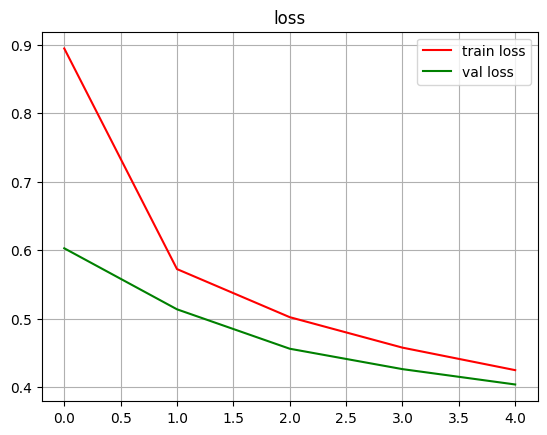

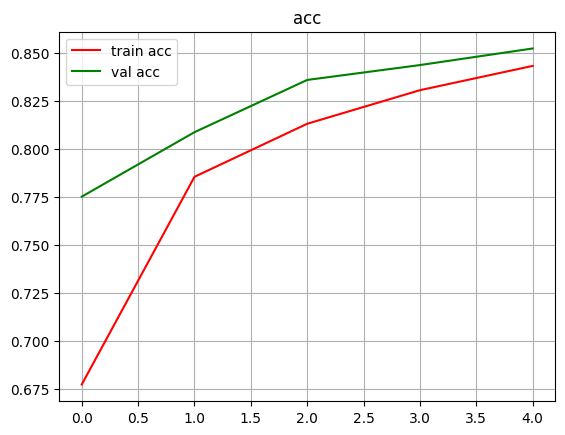

In [74]:
results_model_4_dropout= fit(model_4_dropout, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **32 kernels** de **tamaño 5x5** y **capas dropout intermedias**:

- train loss = 0.42499
- validation loss = 0.40407

- train accuracy = 84.342%
- validation accuracy = 85.251%

Como se puede observar, este modelo ha empeorado su performance respecto a la versión sin capas de dropout.

A continuación, creamos otro modelo con una única capa de dropout a la salida de la última capa de convulución, con una *p= 0.2*.

In [16]:
# creamos la clase
class CNN_4_dropout_1(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 32)
    self.conv1_out = None
    self.conv2 = conv_block(32, 64)
    self.conv2_out = None
    self.conv3 = conv_block(64, 128)
    self.conv3_out = None
    self.dropout = nn.Dropout(p=0.2)
    self.dropout_out = None
    self.fc = torch.nn.Linear(2048, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.dropout_out = self.dropout(self.conv3_out)
    y = self.dropout_out.view(self.dropout_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [17]:
model_4_dropout_1= CNN_4_dropout_1()

Red creada
arquitectura:
CNN_4_dropout_1(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  6
Número total de parámetros a entrenar:  277514


In [18]:
# resumen de la red
summary(model_4_dropout_1.cuda(),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              Tanh-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              Tanh-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]         204,928
              Tanh-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
          Dropout-10            [-1, 128, 4, 4]               0
           Linear-11                   [-1, 10]          20,490
          Softmax-12            [-1, 1, 28, 28]               0
Total params: 277,514
Trainable params: 277,514
Non-trainable params: 0
-------------------------------

In [14]:
model_4_dropout_1.cpu()
model_4_dropout_1.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 32, 14, 14])
Tamaño salida conv2:  torch.Size([1, 64, 7, 7])
Tamaño salida conv3:  torch.Size([1, 128, 4, 4])
Tamaño imagen vectorizada:  torch.Size([1, 2048])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


val_loss 0.50092 val_acc 0.81768: 100%|██████████| 157/157 [00:01<00:00, 84.42it/s]


Epoch 1/5 loss 0.70059 val_loss 0.50092 acc 0.75493 val_acc 0.81768


val_loss 0.40561 val_acc 0.85510: 100%|██████████| 157/157 [00:02<00:00, 68.15it/s]


Epoch 2/5 loss 0.43752 val_loss 0.40561 acc 0.84075 val_acc 0.85510


val_loss 0.36471 val_acc 0.86853: 100%|██████████| 157/157 [00:02<00:00, 77.44it/s]


Epoch 3/5 loss 0.36905 val_loss 0.36471 acc 0.86466 val_acc 0.86853


val_loss 0.33906 val_acc 0.87609: 100%|██████████| 157/157 [00:01<00:00, 85.38it/s]


Epoch 4/5 loss 0.33088 val_loss 0.33906 acc 0.88030 val_acc 0.87609


val_loss 0.32143 val_acc 0.88187: 100%|██████████| 157/157 [00:02<00:00, 66.34it/s]


Epoch 5/5 loss 0.30818 val_loss 0.32143 acc 0.88684 val_acc 0.88187


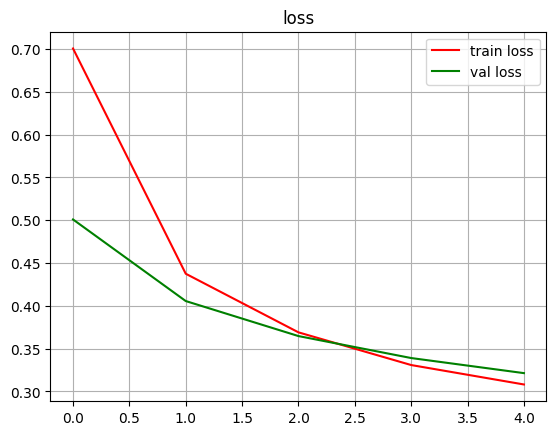

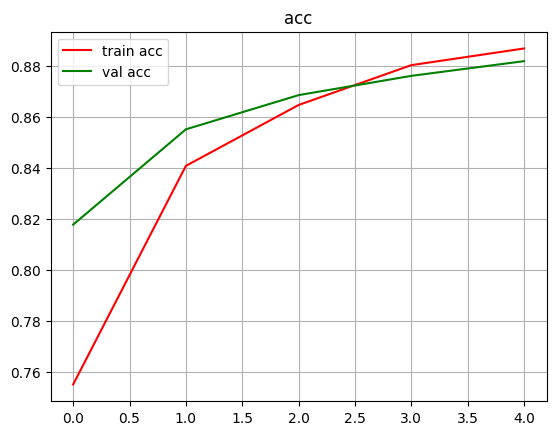

In [19]:
results_model_4_dropout_1= fit(model_4_dropout_1, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **32 kernels** de **tamaño 5x5** y **1 capa dropout final**:

- train loss = 0.07440
- validation loss = 0.06855

- train accuracy = 97.534%
- validation accuracy = 97.641%

En este caso, sí hemos obtenido una muy **leve mejora** en la performance del modelo, por lo que usaremos este último para la siguiente parte de este trabajo.

In [20]:
# guardamos el modelo ya entrenado
checkpoint = {
    'epoch': 5,
    'model_state_dict': results_model_4_dropout_1['model'].state_dict(),
    'optimizer_state_dict': results_model_4_dropout_1['optimizer'].state_dict(),
}

torch.save(checkpoint, 'modelo_pre-entrenado.pth')

## Parte 2.b
Empleando el modelo entrenado y elegido por Ud. en el punto anterior, realice transfer learning para procesar las imágenes del dataset MNIST (los números) e identificar los números mayores o menores a 4,5.
Para el entrenamiento emplee solamente 20.000 muestras del set de entrenamiento y valide con el set de testeo. (al reducir el train set, mantenga equilibrada la distribución de las clases!!)

Pruebe 2 estrategias de transfer learning distintas (acorde a los visto en la teoría) y comente para cada una, cual debería funcionar mejor justificando su respuesta.


Compare los resultados finales y comente.

### Preparación y verificación del dataset

In [21]:
# descargamos datos de entrenamiento
train_data= datasets.MNIST(root= 'data', train= True, download= True, transform= ToTensor())

# descargamos datos de testeo
test_data= datasets.MNIST(root= 'data', train= False, download= True, transform= ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 358587506.31it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35554943.89it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 211301295.34it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9252320.92it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [22]:
# convertimos el problema en una clasificación binaria, según lo indicado por la consigna

# obtenemos las etiquetas actuales
original_labels= train_data.targets

# inicializamos las nuevas etiquetas
new_labels= torch.zeros_like(original_labels)

# aplicamos las transformaciones
new_labels[original_labels <= 4]= 0
new_labels[original_labels > 4]= 1

# actualizamos las etiquetas
train_data.targets= new_labels

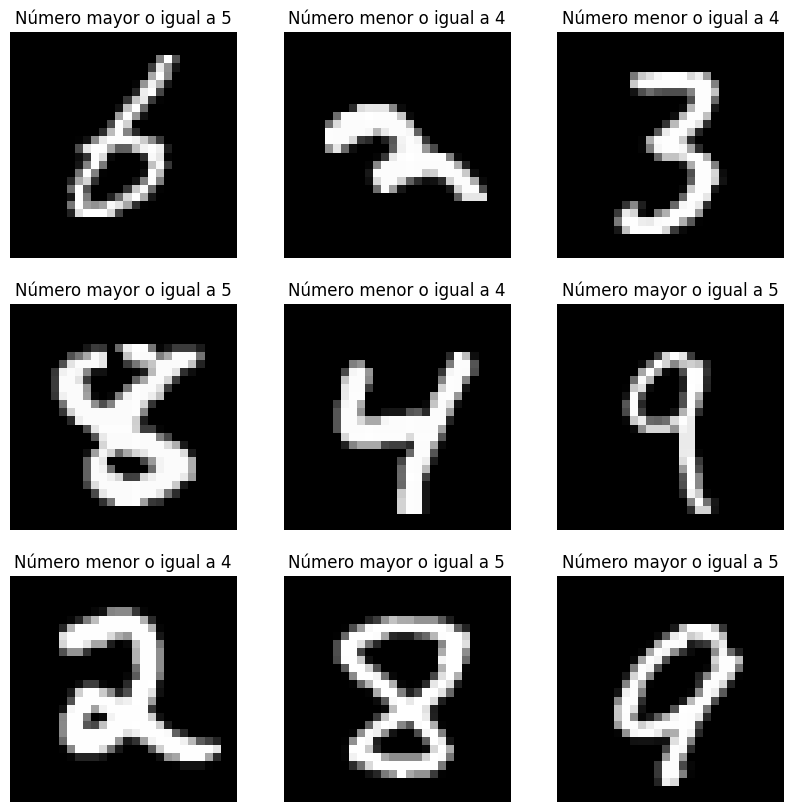

In [23]:
# graficamos todas las clases con sus respectivas etiquetas
labels_map= {
    0: 'Número menor o igual a 4',
    1: 'Número mayor o igual a 5',
}

figure= plt.figure(figsize = (10,10))
cols, rows= 3, 3

for i in range (1, cols*rows + 1):
    sample_idx= torch.randint(len(train_data), size = (1,)).item()
    image, label= train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [24]:
# ahora transformamos los datos de test

# obtenemos las etiquetas actuales
original_labels= test_data.targets

# inicializamos las nuevas etiquetas
new_labels= torch.zeros_like(original_labels)

# aplicamos las transformaciones
new_labels[original_labels <= 4]= 0
new_labels[original_labels > 4]= 1

# actualizamos las etiquetas
test_data.targets= new_labels

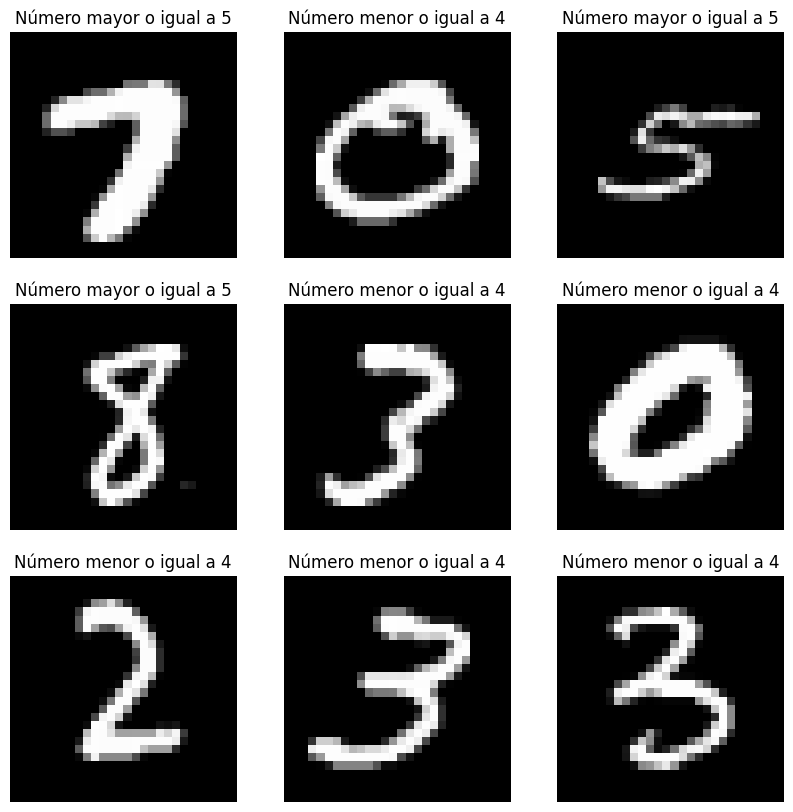

In [25]:
# graficamos todas las clases con sus respectivas etiquetas
labels_map= {
    0: 'Número menor o igual a 4',
    1: 'Número mayor o igual a 5',
}

figure= plt.figure(figsize = (10,10))
cols, rows= 3, 3

for i in range (1, cols*rows + 1):
    sample_idx= torch.randint(len(test_data), size = (1,)).item()
    image, label= test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [26]:
# tomamos una muestra estratificada de 20.000 ejemplos del set de entrenamiento, a fin de mantener las clases balanceadas

# importamos una función de scikitlearn que nos sirve para crear muestras estratificadas
from sklearn.model_selection import StratifiedShuffleSplit

#
labels= [label for _, label in train_data]

# creamos un objeto StratifiedShuffleSplit
sss= StratifiedShuffleSplit(n_splits=1, train_size= 20000, random_state=42)

# obtenemos los índices para el conjunto de datos reducido
train_index, _ = next(sss.split(torch.zeros(len(labels)), labels))

# creamos la muestra estratificada
train_data_stratified= torch.utils.data.Subset(train_data, train_index)

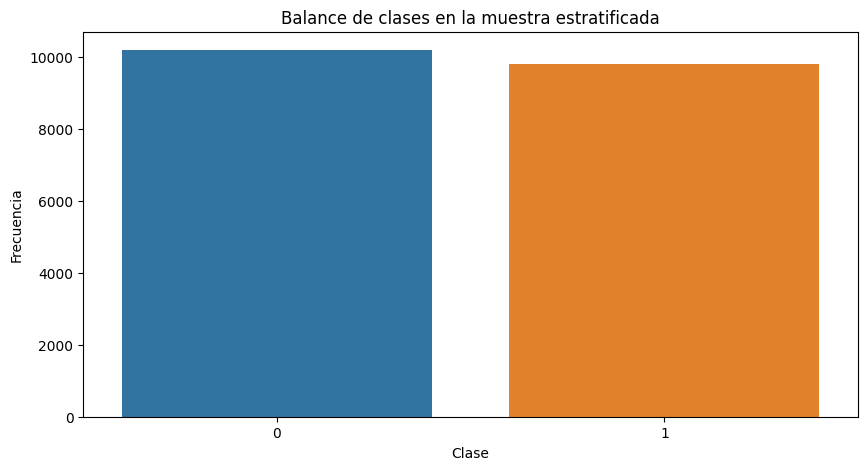

In [27]:
# verificamos graficamente el correcto balance entre las clases
# obtenemos las etiquetas del subset
subset_labels= [label for _, label in train_data_stratified]

# contamos la frecuencia de cada clase en el subset
subset_class_freq= torch.tensor(subset_labels).bincount()

# obtenemos las etiquetas del subset
subset_class_labels= [str(i) for i in range(len(subset_class_freq))]

# importamos seaborn para hacer un barplot
import seaborn as sns

# ploteamos
plt.figure(figsize=(10, 5))
sns.barplot(x= subset_class_labels, y= subset_class_freq.tolist())
plt.title('Balance de clases en la muestra estratificada')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

In [28]:
# creamos los batches con Datalodader
dataloader = {
    'train': torch.utils.data.DataLoader(train_data_stratified, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

In [29]:
# verificamos los types
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [30]:
# capturamos la imagen y etiqueta del dataloader
train_features, train_labels = next(iter(dataloader['train']))

Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


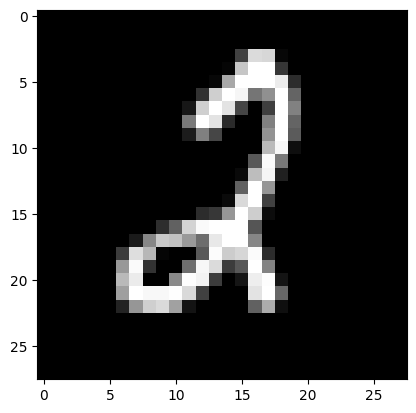

Label: 0


In [31]:
# verificamos las dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[22]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[22]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Transfer learning

#### Fine tuning
Utilizamos esta técnica porque contamos con un **dataset de gran tamaño**, y **suponemos que este es similar** al dataset con el que fue entrenado el modelo a aplicar.

In [32]:
# creamos una nueva clase sin la capa softmax final
class CNN_fine_tuning(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 32)
    self.conv1_out = None
    self.conv2 = conv_block(32, 64)
    self.conv2_out = None
    self.conv3 = conv_block(64, 128)
    self.conv3_out = None
    self.dropout = nn.Dropout(p=0.2)
    self.dropout_out = None
    self.fc = torch.nn.Linear(2048, n_outputs)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.dropout_out = self.dropout(self.conv3_out)
    y = self.dropout_out.view(self.dropout_out.shape[0], -1)
    y = self.fc(y)
    return y

In [33]:
# creamos la instancia del modelo
fine_tuning_model= CNN_fine_tuning()

# cargamos el modelo pre-entrenado que guardamos previamente
pre_trained_model= torch.load('modelo_pre-entrenado.pth')

# cargamos el pre-entrenamiento en el modelo
fine_tuning_model.load_state_dict(pre_trained_model['model_state_dict'])

Red creada
arquitectura:
CNN_fine_tuning(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  277514


<All keys matched successfully>

In [34]:
fine_tuning_model.fc = nn.Linear(2048, 1)
fine_tuning_model

CNN_fine_tuning(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

In [35]:
# resumen de la red
summary(fine_tuning_model.cuda(),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              Tanh-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              Tanh-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]         204,928
              Tanh-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
          Dropout-10            [-1, 128, 4, 4]               0
           Linear-11                    [-1, 1]           2,049
Total params: 259,073
Trainable params: 259,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [36]:
fine_tuning_model.cpu()
fine_tuning_model.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 32, 14, 14])
Tamaño salida conv2:  torch.Size([1, 64, 7, 7])
Tamaño salida conv3:  torch.Size([1, 128, 4, 4])
Tamaño imagen vectorizada:  torch.Size([1, 2048])
Tamaño salida fc (nro clases):  torch.Size([1, 1])


In [37]:
# redefinimos la función para el entrenamiento, a fin de adaptarla a nuestro problema de clasificación binaria
def fit_binary(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss() # cambiamos la función de pérdida
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            y = y.unsqueeze(1) # adaptamos el shape de las etiquetas
            loss = criterion(y_hat, y.float())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = ((y_hat > 0.5) == y.byte()).sum().item() / len(y) # reescribimos el accuracy
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.unsqueeze(1)  # adaptamos el shape de las etiquetas
                loss = criterion(y_hat, y.float())
                val_loss.append(loss.item())
                acc = ((y_hat > 0.5) == y.byte()).sum().item() / len(y) # reescribimos el accuracy
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))

    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

val_loss 0.16089 val_acc 0.93511: 100%|██████████| 157/157 [00:01<00:00, 84.99it/s]


Epoch 1/5 loss 0.29625 val_loss 0.16089 acc 0.87101 val_acc 0.93511


val_loss 0.09943 val_acc 0.96547: 100%|██████████| 157/157 [00:02<00:00, 77.07it/s]


Epoch 2/5 loss 0.12259 val_loss 0.09943 acc 0.95657 val_acc 0.96547


val_loss 0.07908 val_acc 0.97124: 100%|██████████| 157/157 [00:01<00:00, 83.64it/s]


Epoch 3/5 loss 0.08756 val_loss 0.07908 acc 0.96770 val_acc 0.97124


val_loss 0.06645 val_acc 0.97562: 100%|██████████| 157/157 [00:02<00:00, 68.03it/s]


Epoch 4/5 loss 0.06948 val_loss 0.06645 acc 0.97439 val_acc 0.97562


val_loss 0.05902 val_acc 0.97731: 100%|██████████| 157/157 [00:01<00:00, 87.28it/s]


Epoch 5/5 loss 0.05679 val_loss 0.05902 acc 0.98068 val_acc 0.97731


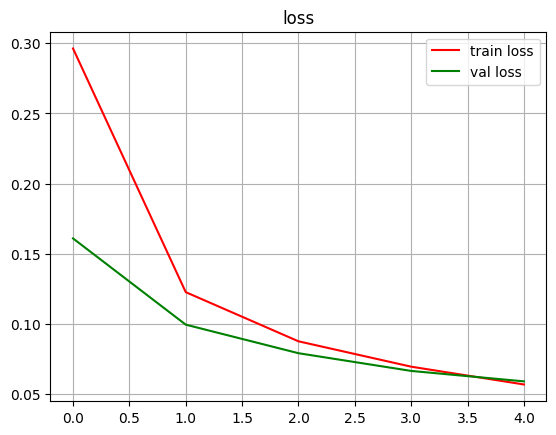

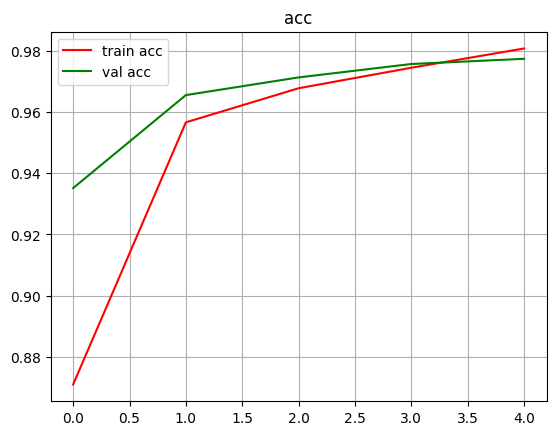

In [38]:
fit_binary(fine_tuning_model, dataloader, epochs=5)

**Se han obtenido excelentes resultados!**

De todas maneras, ahora procederemos a probar otra técnica de transfer learning.

#### Fine tunning (from pre-trained models)
En este caso, **no supondremos que nuestro dataset es similar al dataset con el que fue entrenado el modelo**. Modificaremos el modelo para llevar adelante esta técnica.